In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from matplotlib import pyplot as plt
from sklearn import metrics

## Implementacja neuronu

In [2]:
from abc import ABC, abstractmethod
import logging

class Neuron(ABC):
    def __init__(self, weights: list) -> None:
        self.weights = weights
        self.output = 0
        self.deltas = []
        self.delta = 0
        self.error = 0
        self.input = 0
        self.inputs = []
        if len(weights) < 2:
            logging.warning("Less than 2 weights. Are you sure?")
    
    def __repr__(self) -> str:
        return "%s(weights: %s, output: %s, delta: %s, error: %s)" % (self.name(), str(self.weights), str(self.output), str(self.delta), str(self.error))
            
    @abstractmethod
    def evaluate(self, input: list) -> float:
        pass
    
    @abstractmethod
    def name(self) -> str:
        pass
    
    @abstractmethod
    def derivative(self, output: float) -> float:
        pass
    
    def add_one(l: list) -> list:
        tmp = [1]
        tmp.extend(l)
        return tmp
    
    def dot(a: list, b: list) -> float:
        tmp = min(len(a), len(b))
        return np.dot(a[:tmp], b[:tmp])

    
# pierwsza waga to waga biasu
class LinearNeuron(Neuron):
    def evaluate(self, input: list) -> float:
        self.inputs = Neuron.add_one(input)
        self.output = Neuron.dot(self.weights, self.inputs)
        self.input = self.output
        return self.output
    
    def name(self) -> str:
        return "LinearNeuron"
    
    def derivative(self, output: float) -> float:
        return 1.0
        

class SigmoidNeuron(Neuron):
    def evaluate(self, input: list) -> float:
        self.inputs = Neuron.add_one(input)
        x = Neuron.dot(self.weights, self.inputs)
        self.input = x
#         if abs(x) > 10:
#             print("weights: %s, input: %s" % (self.weights, self.inputs))
        self.output = math.e ** x / (1 + math.e ** x)
        return self.output
    
    def name(self) -> str:
        return "SigmoidNeuron"
    
    def derivative(self, output: float) -> float:
        return output * (1.0 - output)

# tests

assert Neuron.dot([2,3], [5]) == 10
assert Neuron.dot([2,3], [4,5,6]) == 23

linearneuron = LinearNeuron([1,2,3])
assert linearneuron.evaluate([1,2,3]) == 9
assert linearneuron.evaluate([2,3]) == 14

sigmoidneuron = SigmoidNeuron([1, 2])
assert sigmoidneuron.evaluate([1]) == math.e ** 3 / (1 + math.e ** 3)
print(linearneuron)
print(sigmoidneuron)

LinearNeuron(weights: [1, 2, 3], output: 14, delta: 0, error: 0)
SigmoidNeuron(weights: [1, 2], output: 0.9525741268224333, delta: 0, error: 0)


## Implementacja warstwy

In [3]:
class Layer(ABC):
    def __init__(self) -> None:
        self.neurons = []
    
    @abstractmethod
    def __init__(self, num: int, weights: list) -> None:
        pass
        
    def addNeuron(self, neuron: Neuron) -> None:
        self.neurons.append(neuron)
        
    def evaluate(self, input: list) -> list:
        return [neuron.evaluate(input) for neuron in self.neurons]
    
    def __repr__(self) -> str:
        return "Layer(" + str(self.neurons) + ")"
    

class LinearLayer(Layer):
    def __init__(self, num: int, weights: list) -> None:
        assert len(weights) == num, "Invalid matrix dimension"
        self.neurons = [LinearNeuron(w) for w in weights]
    
class SigmoidLayer(Layer):
    def __init__(self, num: int, weights: list) -> None:
        assert len(weights) == num, "Invalid matrix dimension"
        self.neurons = [SigmoidNeuron(w) for w in weights]

# tests
layer1 = LinearLayer(1, [[1, 2]])
assert layer1.evaluate([5]) == [11]
layer1.addNeuron(LinearNeuron([2, 3]))
assert layer1.evaluate([5]) == [11, 17]

layer2 = LinearLayer(2, [[1,2], [2, 3]])
assert layer2.evaluate([5]) == [11, 17]
print(layer2)

Layer([LinearNeuron(weights: [1, 2], output: 11, delta: 0, error: 0), LinearNeuron(weights: [2, 3], output: 17, delta: 0, error: 0)])


## Implementacja sieci

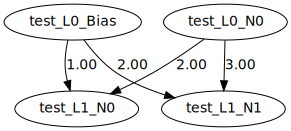

In [295]:
from graphviz import Digraph
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import copy

class Network:
    def __init__(self) -> None:
        self.layers = []
        self.size = []
        self.s = None
    
    def __repr__(self) -> str:
        return "Network(" + "\n\t".join([str(layer) for layer in self.layers]) + ")"
    
    def __init__(self, layer_types: list, size: list, weights=None, gen_type="0|1") -> None:
        assert len(layer_types) == len(size) - 1, "Invalid matrix dimension"
        self.layers = []
        self.size = size
        for i, layer_type in enumerate(layer_types):
            if layer_type == "sigmoid":
                self.addLayerBack(SigmoidLayer(size[i + 1], weights[i] if weights else Network.generate(gen_type, (size[i + 1], size[i] + 1))))
            elif layer_type == "linear":
                self.addLayerBack(LinearLayer(size[i + 1], weights[i] if weights else Network.generate(gen_type, (size[i + 1], size[i] + 1))))
            else:
                logging.error("Invalid layer type")
    
    @staticmethod
    def batch_partition(list_in, n):
        l = copy.deepcopy(list_in)
#         random.shuffle(l)
        return [l[(i * n):(i * n + n)] for i in range(int((len(l) + n - 1) / n))]
        
    def generate(gen_type: str, n: tuple) -> np.array:
        if gen_type == "0|1":
            return np.random.uniform(0, 1, n)
        elif gen_type == "-1|1":
            return np.random.uniform(-1, 1, n)
        elif gen_type == "norm":
            return np.random.normal(0, 1, n)
        elif gen_type == "zero":
            return np.zeros(n)
        
    
    def addLayerBack(self, layer: Layer) -> None:
        self.layers.append(layer)
    
    def forward(self, x: list) -> list:
        input = x
        for layer in self.layers:
            out = []
            for val in input:
                tmp = layer.evaluate(val)
                out.append(tmp)
            input = out
        return input
    
    def predict(self, x):
        return self.s.inverse_transform(self.forward(x))
    
    def draw(self, prefix='', graph=None) -> None:
        g = Digraph(format='svg', name="neural network")
        if graph is not None:
            g = graph
        for idx, layer in enumerate(self.layers):
            current_id = idx + 1
            # create bias neuron
            bias_name = '%s_L%s_Bias' % (prefix, idx)
            g.node(bias_name)
            for n_i, neuron in enumerate(layer.neurons):
                # create dot for neuron
                neuron_name = '%s_L%s_N%s' % (prefix, current_id, n_i)
                g.node(neuron_name)
                # create dots and edges for parents
                for w_i, weight in enumerate(neuron.weights):
                    if w_i == 0:
                        g.edge(bias_name, neuron_name, label=format(weight, '.2f'))
                    else:
                        p_name = '%s_L%s_N%s' % (prefix, idx, w_i - 1)
                        g.node(p_name)
                        g.edge(p_name, neuron_name, label=format(weight, '.2f'))
        return g
            
    def backward_propagate_error(self, expected, l_rate):
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            
            if layer == self.layers[-1]:
                for j, neuron in enumerate(layer.neurons):
                    neuron.error = (expected[j] - neuron.output)
                    neuron.delta = neuron.error * neuron.derivative(neuron.output)
            else:
                next_layer = self.layers[i + 1]
                for j, neuron in enumerate(layer.neurons):
                    for k, next_neuron in enumerate(next_layer.neurons):
                        neuron.error += next_neuron.weights[j+1] * next_neuron.delta
                        neuron.delta += neuron.error * neuron.derivative(neuron.output)
    
    def update_weights(self, l_rate, size):
        for layer in self.layers:
            for neuron in layer.neurons:
                for i in range(len(neuron.weights)):
                    neuron.weights[i] += neuron.delta * neuron.inputs[i] * l_rate / size
    
    def clean_params(self):
        for idx, layer in enumerate(self.layers):
            for neuron in layer.neurons:
                neuron.output = 0
                neuron.delta = 0
                neuron.error = 0
    
    def train_network(self, train_data: list, train_y: list, l_rate=1e-3, n_epoch=5, batch_size=None) -> None:
        self.s = StandardScaler()
        y_std = self.s.fit_transform(train_y)
        joined = [(train_data[i], y_std[i]) for i in range(len(train_y))]
        batches = Network.batch_partition(joined, batch_size) if batch_size else [joined]
        a = self.draw("null")
        for epoch in range(n_epoch):
            for batch_idx, batch in enumerate(batches):
                sum_error = 0
                self.clean_params()
                for i, row in enumerate(batch):
                    x, expected = row
                    outputs = self.forward([row])
                    sum_error += sum([(expected[i]-outputs[0][i])**2 for i in range(len(expected))])
                    self.backward_propagate_error(expected, l_rate)
                self.update_weights(l_rate, len(batch))
            if epoch % 100 == 99:
                a = self.draw(str(epoch), a)
#             print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
        return a
        

# tests
network = Network(["linear"], [1, 1], [[[1,2,3]]])
assert network.forward([[2,3]]) == [[14]]

network2 = Network(["linear"], [1, 2], [
        [[1,2], [2, 3]]
])
assert network2.forward([[5]]) == [[11, 17]]
network2.draw("test")
# https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/

# Zbiór square-simple

In [135]:
train_df = pd.read_csv('./mio1/regression/square-simple-training.csv', index_col=0)
test_df = pd.read_csv('./mio1/regression/square-simple-test.csv', index_col=0)

### jedna warstwa ukryta, 10 neuronów

CPU times: user 1.92 s, sys: 16 ms, total: 1.94 s
Wall time: 1.91 s


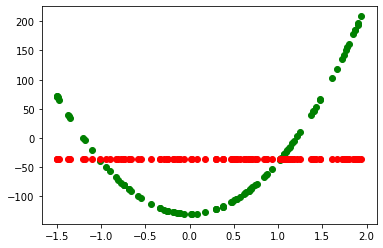

In [299]:
%%time
# 1111
np.random.seed(2137)
mlp = Network(["sigmoid", "linear"], [1,4,1], gen_type="zero")
g = mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=500, l_rate=1e-2)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

In [233]:
best_seed = 0
best_val = 100000000
for i in range(150,550):
    np.random.seed(i)
    mlp = Network(["sigmoid", "linear"], [1,5,1], gen_type="0|1")
    g = mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=500, l_rate=1e-2)

    y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
    y_pred = np.squeeze(y_pred)
    val = metrics.mean_absolute_error(train_df['y'], y_pred)
    if val < best_val:
        best_val = val
        best_seed = i

In [234]:
best_seed

395

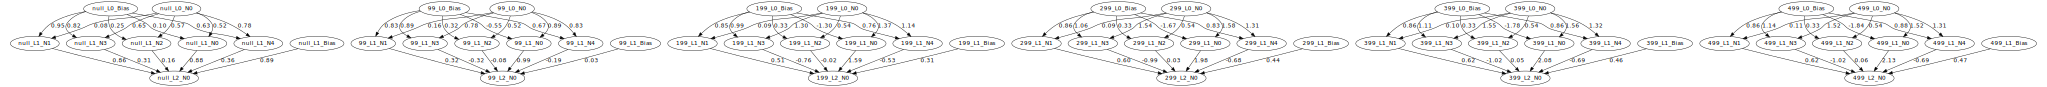

In [75]:
g

##### Wynik na zbiorze treningowym

In [184]:
metrics.mean_absolute_error(train_df['y'], y_pred)

91.6061210232922

##### Wynik na zbiorze testowym

In [77]:
y_pred = mlp.predict(np.expand_dims(test_df['x'], 1))
y_pred = np.squeeze(y_pred)
metrics.mean_absolute_error(test_df['y'], y_pred)

10.26791227491678

CPU times: user 3.65 s, sys: 16 ms, total: 3.67 s
Wall time: 3.68 s


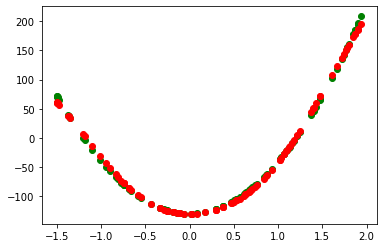

In [267]:
%%time
np.random.seed(2137)
mlp = Network(["sigmoid", "linear"], [1,4,1])
g = mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=500, l_rate=1e-2, batch_size=1)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Wynik na zbiorze treningowym

In [77]:
metrics.mean_absolute_error(train_df['y'], y_pred)

19.285010695832717

##### Wynik na zbiorze testowym

In [78]:
y_pred = mlp.forward(np.expand_dims(test_df['x'], 1))
y_pred = np.squeeze(y_pred)
metrics.mean_absolute_error(test_df['y'], y_pred)

19.104502371942342

# Zbiór steps-small

In [309]:
train_df = pd.read_csv('./mio1/regression/steps-large-training.csv', index_col=0)
test_df = pd.read_csv('./mio1/regression/steps-large-test.csv', index_col=0)

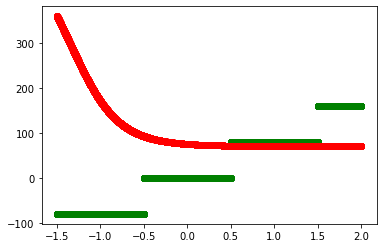

In [302]:
%%time
np.random.seed(2137)
mlp = Network(["sigmoid", "linear"], [1,10,1])
mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=10, l_rate=1e-3)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Wynik na zbiorze treningowym

In [77]:
metrics.mean_absolute_error(train_df['y'], y_pred)

19.285010695832717

##### Wynik na zbiorze testowym

In [78]:
y_pred = mlp.forward(np.expand_dims(test_df['x'], 1))
y_pred = np.squeeze(y_pred)
metrics.mean_absolute_error(test_df['y'], y_pred)

19.104502371942342

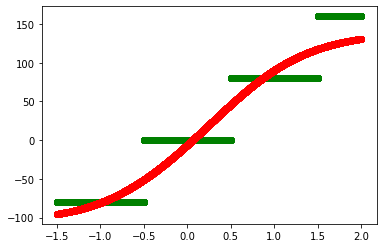

In [308]:
%%time
np.random.seed(2137)
mlp = Network(["sigmoid", "linear"], [1,10,1])
mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=10, l_rate=1e-1, batch_size=8)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Wynik na zbiorze treningowym

In [77]:
metrics.mean_absolute_error(train_df['y'], y_pred)

19.285010695832717

##### Wynik na zbiorze testowym

In [78]:
y_pred = mlp.forward(np.expand_dims(test_df['x'], 1))
y_pred = np.squeeze(y_pred)
metrics.mean_absolute_error(test_df['y'], y_pred)

19.104502371942342

# Zbiór multimodal-large

In [322]:
train_df = pd.read_csv('./mio1/regression/multimodal-large-training.csv', index_col=0)
test_df = pd.read_csv('./mio1/regression/multimodal-large-test.csv', index_col=0)

CPU times: user 4.62 s, sys: 8 ms, total: 4.62 s
Wall time: 4.6 s


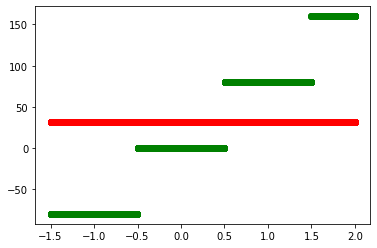

In [323]:
%%time
np.random.seed(1111)
mlp = Network(["sigmoid", "linear"], [1,5,1])
mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=10, l_rate=1e-1)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Wynik na zbiorze treningowym

In [324]:
metrics.mean_absolute_error(train_df['y'], y_pred)

72.82729584878822

##### Wynik na zbiorze testowym

In [325]:
y_pred = mlp.forward(np.expand_dims(test_df['x'], 1))
y_pred = np.squeeze(y_pred)
metrics.mean_absolute_error(test_df['y'], y_pred)

67.30271606891978

CPU times: user 8.85 s, sys: 152 ms, total: 9 s
Wall time: 8.86 s


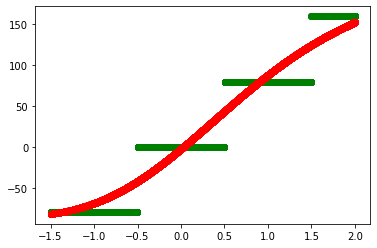

In [331]:
%%time
np.random.seed(2137)
mlp = Network(["sigmoid", "linear"], [1,10,1])
mlp.train_network(np.expand_dims(train_df['x'], 1), np.expand_dims(train_df['y'], 1), n_epoch=10, l_rate=1e-1, batch_size=8)

y_pred = mlp.predict(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Wynik na zbiorze treningowym

In [332]:
metrics.mean_absolute_error(train_df['y'], y_pred)

18.999284783047678

##### Wynik na zbiorze testowym

In [334]:
y_pred = mlp.forward(np.expand_dims(test_df['x'], 1))
y_pred = np.squeeze(y_pred)
metrics.mean_absolute_error(test_df['y'], y_pred)

66.6380759162221

# Wnioski
Zdecydowanie widać, że metoda z batchem jest trochę wolniejsza niż poprawianie wag dopiero po całym zbiorze, ale daje też znacznie lepsze wyniki. Poprawianie wag po całym zbiorze pokazuje, jak ważne są wstępne wagi, gdyż od nich niestety w dużej mierze zależy dokładność i kształt finalnej funkcji.